## _PandaML_

- Perform detailed Exploratory Data Analysis on STT Data.

In [1]:
import os
import glob
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import trackml.dataset
import tensorflow as tf
import seaborn as sns

## Dataset

In [3]:
# path to the dataset
path = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [4]:
# select an event
event_id = 2

In [5]:
# load event using trackml.dataset (update: pandaroot will now generate tubes.csv as cells.csv)
event_prefix = str('event{!s}'.format(format(event_id, '010d')))
prefix = path + str('event{!s}'.format(format(event_id, '010d')))
hits, tubes, particles, truth = trackml.dataset.load_event(prefix)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event0000000002 memory usage 0.01 MB


In [6]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-6.12280,-15.655000,35.0,9,0,48
1,2,-6.99749,-16.160000,35.0,9,1,154
2,3,-6.99749,-17.170000,35.0,9,2,267
3,4,-7.87217,-17.674999,35.0,9,3,385
4,5,-7.87217,-18.684999,35.0,9,4,510


In [7]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.062153,15273000.0,15.27300,9,0,48,0,2
1,2,0.485507,2901860.0,2.90186,9,1,154,0,2
2,3,0.084492,12518600.0,12.51860,9,2,267,0,2
3,4,0.366787,6127680.0,6.12768,9,3,385,0,2
4,5,0.218553,14618900.0,14.61890,9,4,510,0,2


In [8]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.000000,-0.000000,1.642000,0,1,88888,0
1,2,0.0,0.0,0.0,-0.080749,-0.009465,0.498454,0,1,2212,0
2,3,0.0,0.0,0.0,-0.097025,0.039273,0.212149,0,1,-211,0
3,4,0.0,0.0,0.0,0.201635,0.091849,0.697453,0,1,-2212,0
4,5,0.0,0.0,0.0,-0.023861,-0.121658,0.233945,0,1,211,0


In [9]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-6.13515,-15.647600,31.807100,-0.062007,-0.103075,0.224405,0.0,5
1,2,-6.60323,-16.410000,33.474800,-0.064706,-0.101951,0.224082,0.0,5
2,3,-7.06991,-17.121700,35.050701,-0.066850,-0.100841,0.223882,0.0,5
3,4,-7.58211,-17.876499,36.736900,-0.069040,-0.099612,0.223697,0.0,5
4,5,-8.05966,-18.549700,38.261200,-0.070896,-0.098117,0.223732,0.0,5


## Particles

The particles files contains the following values for each particle/entry:  
* __particle_id__: numerical identifier of the particle inside the event.
* __vx, vy, vz__: initial position or vertex (in millimeters) in global coordinates.
* __px, py, pz__: initial momentum (in GeV/c) along each global axis.
* __q__: particle charge (as multiple of the absolute electron charge).
* __nhits__: number of hits generated by this particle.

The particle data help us understand each particle's initial __position__, __momentum__, and __charge__, which we can join with the event truth dataset to get the particle's final position and momentum. This is needed to identify the tracks that each particle generated.

In [34]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.000000,-0.000000,1.642000,0,1,88888,0
1,2,0.0,0.0,0.0,-0.080749,-0.009465,0.498454,0,1,2212,0
2,3,0.0,0.0,0.0,-0.097025,0.039273,0.212149,0,1,-211,0
3,4,0.0,0.0,0.0,0.201635,0.091849,0.697453,0,1,-2212,0
4,5,0.0,0.0,0.0,-0.023861,-0.121658,0.233945,0,1,211,0


In [33]:
particles.tail()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.000000,-0.000000,1.642000,0,1,88888,0
1,2,0.0,0.0,0.0,-0.080749,-0.009465,0.498454,0,1,2212,0
2,3,0.0,0.0,0.0,-0.097025,0.039273,0.212149,0,1,-211,0
3,4,0.0,0.0,0.0,0.201635,0.091849,0.697453,0,1,-2212,0
4,5,0.0,0.0,0.0,-0.023861,-0.121658,0.233945,0,1,211,0


In [35]:
particles.describe()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
count,5.000000,5.0,5.0,5.0,5.000000e+00,5.000000e+00,5.000000,5.0,5.0,5.000000,5.0
mean,3.000000,0.0,0.0,0.0,3.948808e-08,-8.046627e-08,0.656800,0.0,1.0,17777.600000,0.0
std,1.581139,0.0,0.0,0.0,1.195411e-01,7.884934e-02,0.586060,0.0,0.0,39782.961696,0.0
min,1.000000,0.0,0.0,0.0,-9.702490e-02,-1.216580e-01,0.212149,0.0,1.0,-2212.000000,0.0
25%,2.000000,0.0,0.0,0.0,-8.074930e-02,-9.464710e-03,0.233945,0.0,1.0,-211.000000,0.0
50%,3.000000,0.0,0.0,0.0,-2.386060e-02,0.000000e+00,0.498454,0.0,1.0,211.000000,0.0
75%,4.000000,0.0,0.0,0.0,0.000000e+00,3.927340e-02,0.697453,0.0,1.0,2212.000000,0.0
max,5.000000,0.0,0.0,0.0,2.016350e-01,9.184890e-02,1.642000,0.0,1.0,88888.000000,0.0


### (1) Hit Rate and Charge Distribution
Let's see the distribution of the number of hits per particle, shown below.  A significant number of particles had no attributed hits, and most of them have positive charge in this event.

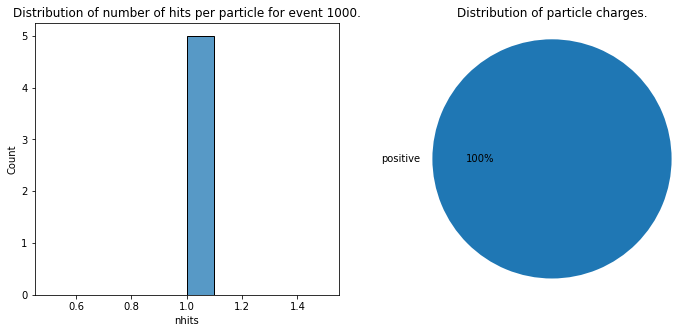

In [67]:
# using the seaborn with pyplot API for subplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
_ = sns.histplot(data=particles, x='nhits', bins=10) # bins=particles.nhits.max()
plt.title('Distribution of number of hits per particle for event 1000.')

plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        #labels=['negative', 'positive'],
        labels=['positive'],
        autopct='%.0f%%',
        radius=1.1)
plt.title('Distribution of particle charges.')
plt.show()

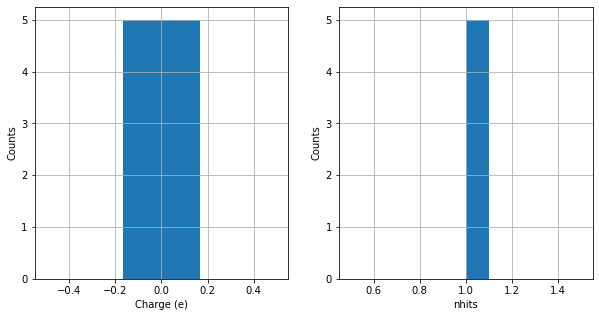

In [70]:
# using the pyplot API for subplots
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
particles.q.hist(bins=3)
plt.xlabel('Charge (e)')
plt.ylabel('Counts')

plt.subplot(1,2,2)
particles.nhits.hist(bins=10) # bins=particles.nhits.max()
plt.xlabel('nhits')
plt.ylabel('Counts')

plt.show()

### (2) Initial Position and Momentum
Let's now take a look at the initial position of the particles around the global coordinates' origin $(x, y)=(0,0)$, as shown in the figure below.

The initial position distribution is more concentrated around the origin (less variance) than its hit position (shown above under the Hits Data section).  As the particles hit the detection surface, they tend to scatter as shown in the particle trajectory plot at the end of this notebook.

The colors here show the number of hits for each particle.

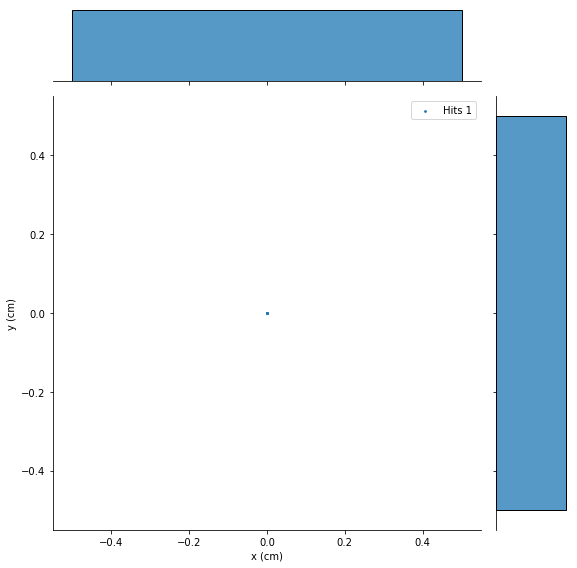

In [71]:
# One needs nhits per particle/track which current set as 1 as placeholder.
# The 'nhits' field is under construction...

g = sns.jointplot(data=particles, x='vx', y='vy',  s=3, height=8)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vx, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.show()

And here is the initial position of the particles in a $z$, $y$ view.  Colors show number of hits.

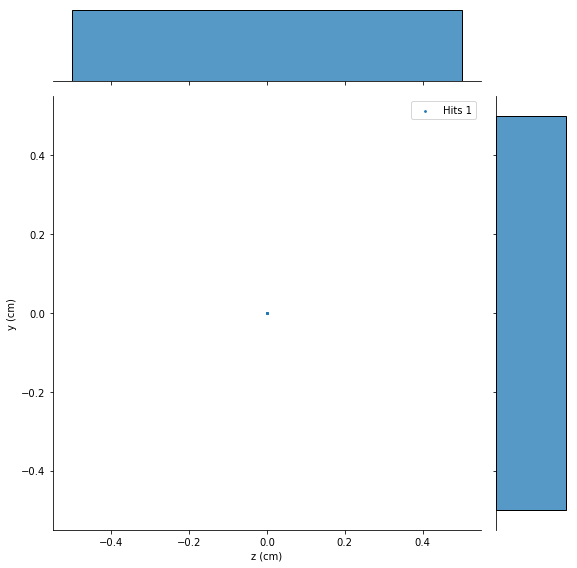

In [72]:
g = sns.jointplot(data=particles, x='vz', y='vy', s=3, height=8)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vz, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('z (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.show()

And this is what they look like in 3D.

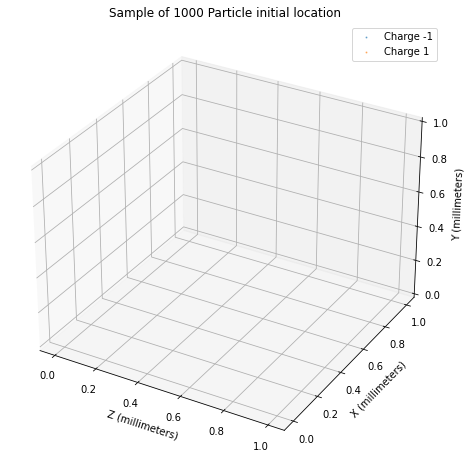

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for charge in [-1, 1]:
    q = particles[particles.q == charge]
    ax.scatter(q.vz, q.vx, q.vy, s=1, label='Charge {}'.format(charge), alpha=0.5)

ax.set_title('Sample of 1000 Particle initial location')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

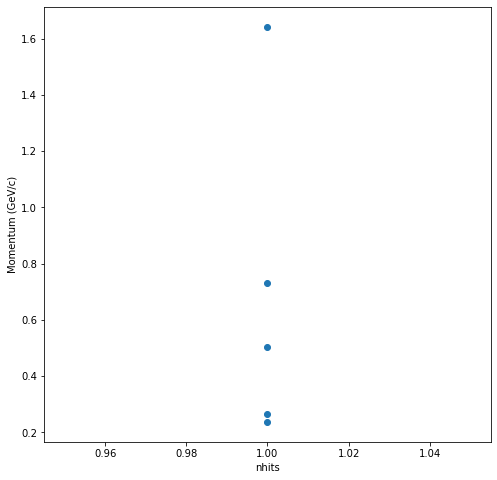

In [75]:
# let's look into the total momentum of particles w.r.t nhits
plt.figure(figsize=(8,8))
p = np.sqrt(particles.px**2 + particles.py**2 + particles.pz**2)
plt.scatter(particles.nhits, p)
#plt.yscale('log')
plt.xlabel('nhits')
plt.ylabel('Momentum (GeV/c)')
plt.show()

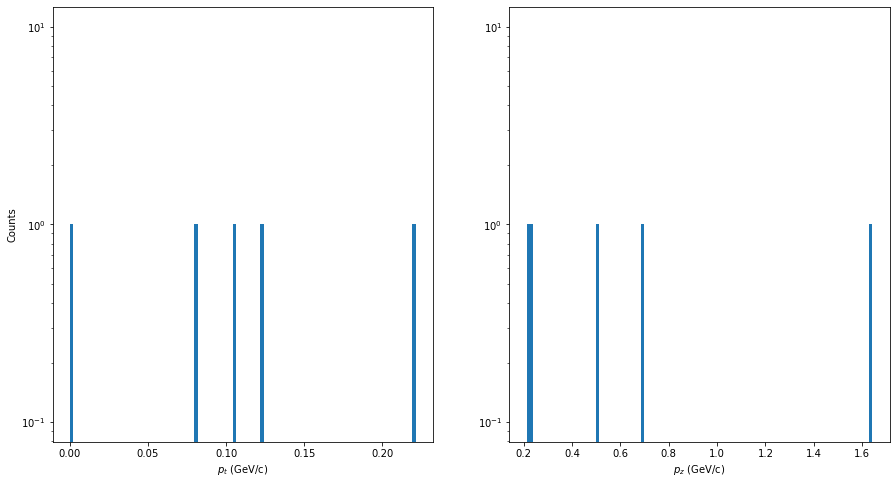

In [80]:
# more on momentum of particles
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
#plt.xscale('log')
plt.hist(np.sqrt(particles.px**2 + particles.py**2), bins=100, log=True)
plt.xlabel(r'$p_t$ (GeV/c)')
plt.ylabel('Counts')
plt.subplot(1,2,2)
#plt.xscale('log')
plt.hist(particles.pz.abs(), bins=100, log=True)
plt.xlabel(r'$p_z$ (GeV/c)')
plt.show()

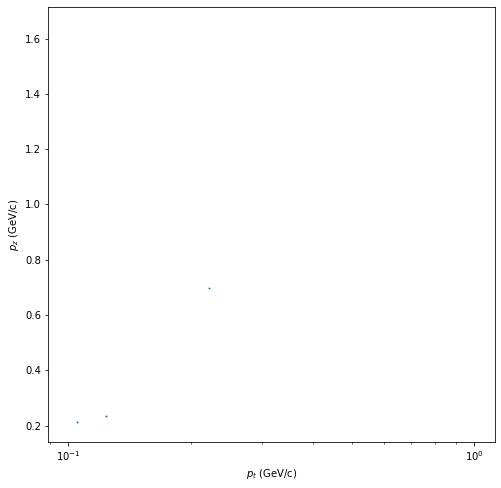

In [82]:
# What about p_t vs p_z?
plt.figure(figsize=(8,8))
plt.scatter(np.sqrt(particles.px**2 + particles.py**2), particles.pz, s=1)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$p_t$ (GeV/c)')
plt.ylabel(r'$p_z$ (GeV/c)')
#plt.zlabel('Counts')
plt.show()

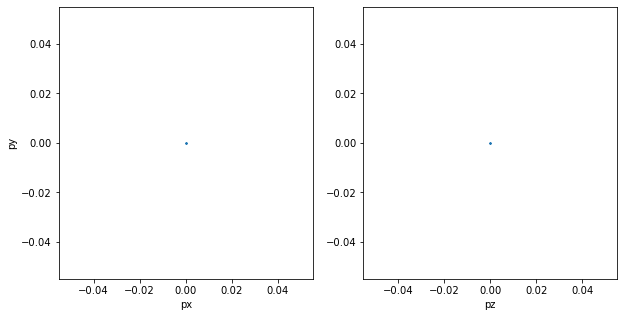

In [84]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(particles.vx, particles.vy, s=1)
plt.xlabel('px')
plt.ylabel('py')
plt.subplot(1,2,2)
plt.scatter(particles.vz, particles.vy, s=1)
plt.xlabel('pz')
plt.show()

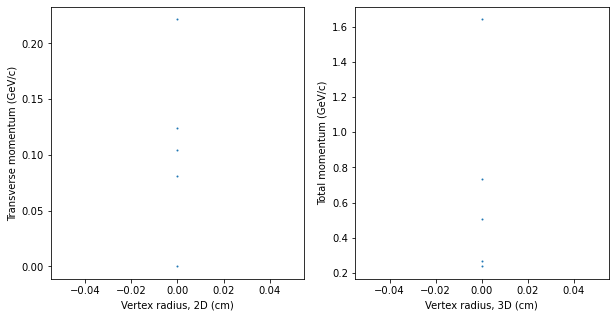

In [87]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.sqrt(particles.vx**2+particles.vy**2), np.sqrt(particles.px**2+particles.py**2), s=1)
plt.xlabel('Vertex radius, 2D (cm)')
plt.ylabel('Transverse momentum (GeV/c)')
#plt.xscale('log')
#plt.yscale('log')
plt.subplot(1,2,2)
plt.scatter(np.sqrt(particles.vx**2+particles.vy**2+particles.vz**2), np.sqrt(particles.px**2+particles.py**2+particles.pz**2), s=1)
plt.xlabel('Vertex radius, 3D (cm)')
plt.ylabel('Total momentum (GeV/c)')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

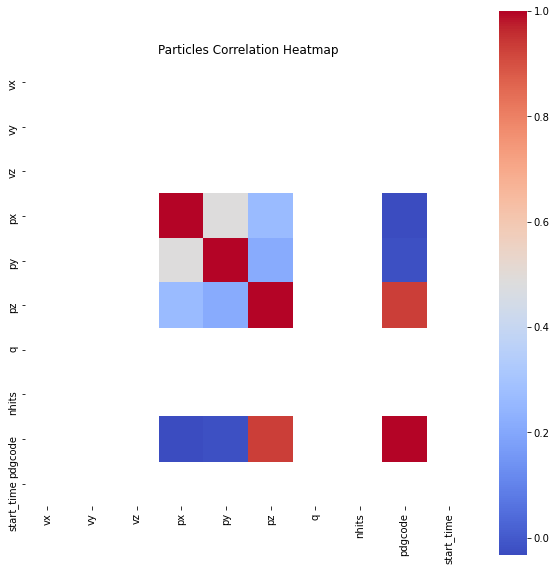

In [88]:
plt.figure(figsize=(10, 10))
particlescorr = particles.drop('particle_id', axis=1).corr()
sns.heatmap(particlescorr, cmap='coolwarm', square=True)
plt.title('Particles Correlation Heatmap')
plt.show()

### (3) Particle Trajectory
We can reconstruct the trajectories for a few particles given their intersection points with the detection layers.  As explained in the [competition evaluation page][ceval], hits from straight tracks have larger wieghts, and random tracks or hits with very short tracks have weights of zero.  The figure below shows two such examples.

Thanks to [maka's notebook][traj] for the idea.

[traj]: https://www.kaggle.com/makahana/quick-trajectory-plot
[ceval]: https://www.kaggle.com/c/trackml-particle-identification#evaluation

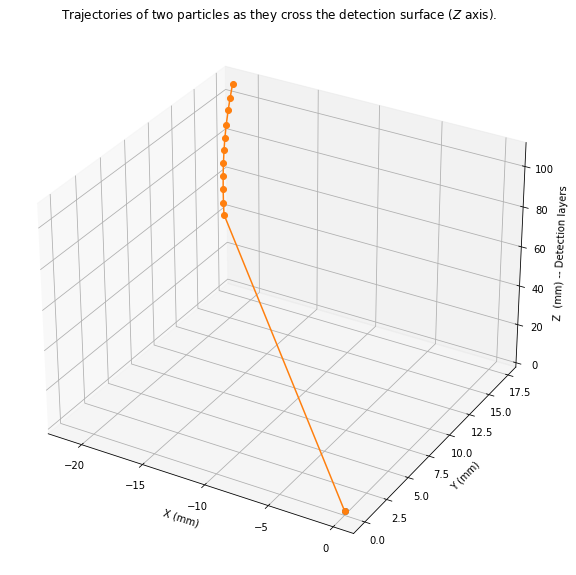

In [32]:
# Get particle id with max number of hits in this event
particle = particles.loc[particles.nhits == particles.nhits.max()].iloc[0]
particle2 = particles.loc[particles.nhits == particles.nhits.max()].iloc[1]

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_surface = truth[truth.particle_id == particle.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]

p_traj = (p_traj_surface
          .append({'tx': particle.vx, 'ty': particle.vy, 'tz': particle.vz}, ignore_index=True)
          .sort_values(by='tz'))
p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj.tx,
    ys=p_traj.ty,
    zs=p_traj.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()